# Newton's 3rd Law

### **Introduction**

Newton's Third Law of Motion is one of the most well-known and intuitive principles of physics. It states that: "For every action, there is an equal and opposite reaction."
This law emphasizes that forces always come in pairs—when one object exerts a force on another, the second object exerts a force of equal magnitude in the opposite direction on the first object. The two forces are equal in strength but act in opposite directions. This law highlights the interaction between objects and is fundamental to understanding how forces work in the universe.


### **What is it?**

Newton’s Third Law explains that forces are always mutual. Whenever an object exerts a force on another object, the second object exerts a force back on the first object. These forces are equal in size but opposite in direction. It's important to note that these action-reaction forces do not cancel each other out because they act on different objects. For example, if you push against a wall, the wall pushes back on you with an equal and opposite force.

This law is essential for understanding how objects interact with one another. It is key to many real-world phenomena, including walking, flying, and swimming.


### **Example**

1. **Walking:** When you walk, your foot pushes backward against the ground (this is the action force). According to Newton’s Third Law, the ground pushes forward on your foot with an equal and opposite force (the reaction force). It is this forward push from the ground that allows you to move forward.

2. **Jumping off a boat:** If you're standing in a small boat on water and you push off the side to jump, you’ll notice that the boat moves backward as you move forward. When you push on the boat (action), the boat pushes back on you with an equal force (reaction). The boat’s backward movement is the result of this reaction force.

3. **Rocket Propulsion:** In a rocket launch, the rocket expels gas downwards with a powerful force (action). In response, the rocket experiences an equal and opposite force (reaction), which pushes it upwards, allowing it to take off. This principle is crucial to the functioning of rockets and space exploration.

4. **Recoil of a gun:** When a gun is fired, the bullet is pushed forward by the explosion of gunpowder (action), and at the same time, the gun is pushed backward with an equal force (reaction). This backward movement of the gun is what we call "recoil."

Newton’s Third Law explains a wide variety of everyday occurrences and helps us understand the fundamental interactions between objects. It shows that no force exists in isolation—there is always an equal and opposite force acting on another object.


# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mujoco, mjcf
from dm_control.mujoco.wrapper.mjbindings import enums

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [4]:
# global
viscosity = 0.00000  # Air Resistance

# simulation constants
force = 5000  # [N]

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
import os, sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from scene import Scene

### Objects of Interest

Here we create all the objects that will interact in the world. To model `action - reaction` one might create a cannon that will shoot a cannonball.

In [6]:
class CannonBall(object):

    def __init__(self, size: float, mass: float) -> None:
        self.model = mjcf.RootElement(model="cannonball")

        self.sphere = self.model.worldbody.add("body", name="sphere", pos=[0, 0, 0])
        self.sphere_geom = self.sphere.add(
            "geom",
            name="sphere_geom",
            type="sphere",
            size=[size],
            rgba=[0.1, 0.1, 0.15, 1],
            mass=mass,
        )

        # self.sphere.add("joint", name="rotate", type="hinge", axis=[0, 1, 0])
        self.sphere.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.sphere.add("joint", name="fall", type="slide", axis=[0, 0, 1])

        self.camera = self.sphere.add(
            "camera",
            name="side",
            pos=[0, -2, 1],
            euler=[75, 0, 0],
            mode="track",
        )

In [7]:
class Cannon(object):

    def __init__(self) -> None:
        self.model = mjcf.RootElement(model="cannon")

        self.cannon = self.model.worldbody.add("body", name="cannon", pos=[0, 0, 0])

        # cannon joints
        self.move = self.cannon.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.cannon.add("joint", name="fall", type="slide", axis=[0, 0, 1])

        # constants
        self.barrel_length = 1
        self.barrel_r = 0.2
        self.wheel_r = 0.25

        # barrel
        self.barrel_pos = [0, 0, self.barrel_r + self.wheel_r + 0.025]
        self.barrel_site = self.cannon.add("site", pos=self.barrel_pos)
        self.barrel_model = self.add_barrel(barrel_parts_num=60)
        self.barrel_site.attach(self.barrel_model)

        # base of cannon
        self.base_site = self.cannon.add(
            "site", pos=[-self.barrel_length / 10, 0, self.wheel_r]
        )
        self.base_model = self.add_base()
        self.base_site.attach(self.base_model)

        self.camera = self.cannon.add(
            "camera",
            name="side",
            pos=[0, -2, 1],
            euler=[75, 0, 0],
            mode="track",
        )

    def add_barrel(self, barrel_parts_num: int) -> mjcf.Element:
        self.barrel_model = mjcf.RootElement(model="cannon_barrel")
        self.barrel = self.barrel_model.worldbody.add(
            "body", name="barrel", pos=[0, 0, 0], euler=[0, 90, 0]
        )

        rgba = [0.4, 0.4, 0.4, 1]
        self.barrel_base_ring = self.barrel.add(
            "geom",
            name="barrel_base_ring",
            type="cylinder",
            size=[self.barrel_r + 0.02, 0.025],
            pos=[0, 0, -self.barrel_length / 2 + 0.025],
            rgba=rgba,
        )
        self.barrel_base = self.barrel.add(
            "geom",
            name="barrel_base",
            type="cylinder",
            size=[self.barrel_r / 1.5, 0.015],
            pos=[0, 0, -self.barrel_length / 2],
            rgba=rgba,
        )
        self.barrel_neck = self.barrel.add(
            "geom",
            name="barrel_neck",
            type="cylinder",
            size=[self.barrel_r / 5, 0.025],
            pos=[0, 0, -self.barrel_length / 2 - (0.025 + 0.015)],
            rgba=rgba,
        )
        self.barrel_knob = self.barrel.add(
            "geom",
            name="barrel_knob",
            type="sphere",
            size=[self.barrel_r / 3],
            pos=[0, 0, -self.barrel_length / 2 - (0.025 + 0.015) - self.barrel_r / 3],
            rgba=rgba,
        )

        for i in range(1, barrel_parts_num + 1):
            angle = 2 * i * np.pi / barrel_parts_num
            barrel_pos = self.barrel_r * np.array([np.cos(angle), np.sin(angle), 0])
            self.barrel.add(
                "geom",
                name=f"barrel_{i}",
                type="box",
                size=[0.012, 0.01, self.barrel_length / 2],
                pos=barrel_pos,
                rgba=rgba,
                mass=1,
                euler=[0, 0, np.rad2deg(angle) + 90],
            )

        return self.barrel_model

    def add_base(self) -> mjcf.Element:
        self.base_model = mjcf.RootElement(model="cannon_base")
        rgba = [0.79, 0.55, 0.15, 1]

        self.cannon_base = self.base_model.worldbody.add(
            "geom",
            name="base",
            type="box",
            size=[0.15, 0.25, 0.025],
            rgba=rgba,
            mass=100,
        )
        for i in [-1, 1]:
            wheel = self.base_model.worldbody.add(
                "body", name=f"wheel_{'r' if i > 0 else 'l'}", pos=[0, 0.25 * i, 0]
            )
            wheel.add(
                "geom",
                name=f"wheel_{'r' if i > 0 else 'l'}",
                type="cylinder",
                size=[self.wheel_r, 0.025],
                rgba=rgba,
                mass=5,
                euler=[90, 0, 0],
                pos=[0, 0, 0],
            )
            rotate = wheel.add(
                "joint",
                name=f"rotate_{'r' if i > 0 else 'l'}",
                type="hinge",
                axis=[0, 1, 0],
            )
            self.base_model.actuator.add("motor", joint=rotate)

        return self.base_model

### World Model

Collecting everything into one general model

In [8]:
class Model(object):

    def __init__(self) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        # set the simulation constants
        self.model.option.viscosity = viscosity
        self.model.option.integrator = "RK4"
        self.model.option.timestep = 0.001

        # create the scene (ground)
        self.scene = Scene(length=0)
        self.scene_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.scene_site.attach(self.scene.model)

        # create cannon
        self.cannon = Cannon()
        self.cannon_site = self.model.worldbody.add(
            "site", name="cannon_site", pos=[0, 0, 0]
        )
        self.cannon_site.attach(self.cannon.model)

        # create cannonball
        self.cannonball = CannonBall(size=self.cannon.barrel_r * 0.9, mass=10)
        self.cannon_site = self.model.worldbody.add(
            "site",
            name="cannonball_site",
            pos=[
                -self.cannon.barrel_length / 2 + self.cannon.barrel_r * 1.5,
                0,
                self.cannon.barrel_pos[2],
            ],
        )
        self.cannon_site.attach(self.cannonball.model)

## Simulation

Initializing the `physics` of the simulation

In [9]:
model = Model().model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture

""

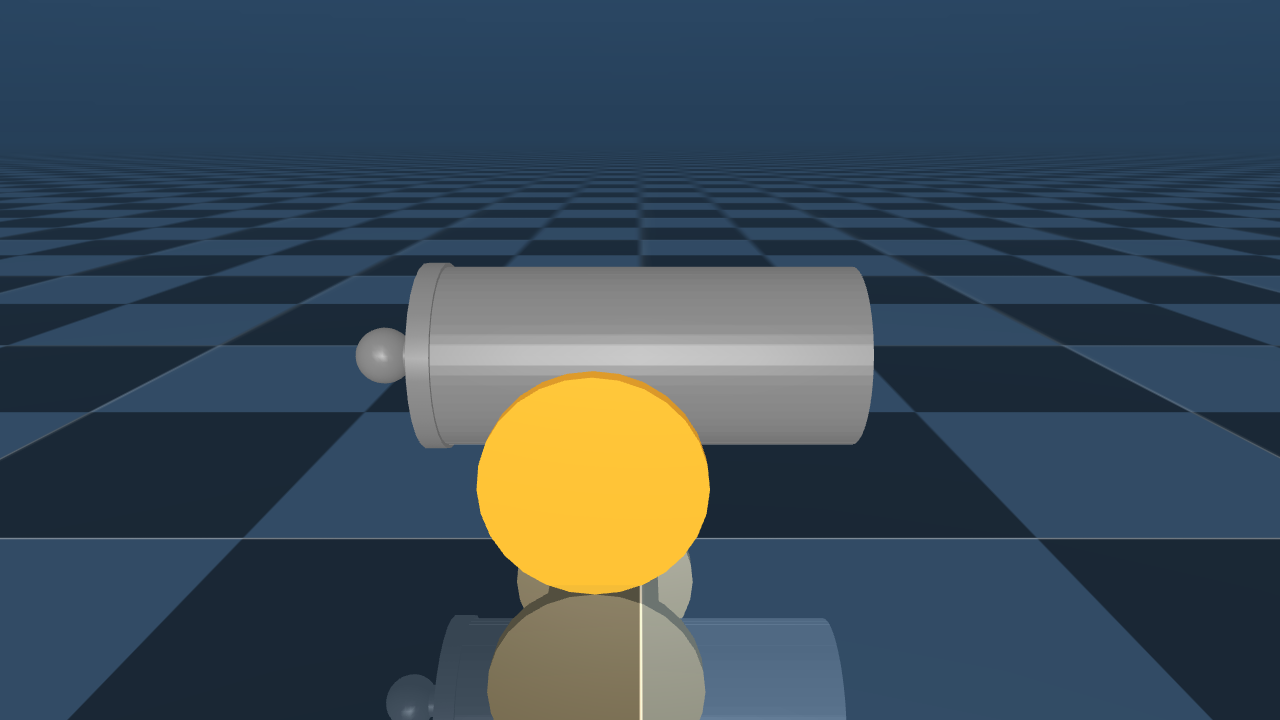

In [10]:
physics.step()

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_PERTOBJ] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_PERTFORCE] = True

mediapy.show_image(physics.render(width=width, height=height, camera_id=0))

### Simulation Loop

In [11]:
frames = []
timevals = []
cannon_velocity = []
ball_velocity = []

started = None
stopped = None
while physics.data.time < duration:
    physics.step()

    if started is not None and stopped is None:
        if physics.time() - started > 0.1:
            physics.named.data.xfrc_applied["cannonball/sphere"][0] = 0
            physics.named.data.xfrc_applied["cannon/cannon"][0] = 0

    if physics.time() > 1 and started is None:
        print(True)
        # apply force to demonstrate the Newton's 3rd law
        physics.named.data.xfrc_applied["cannonball/sphere"][0] = force
        physics.named.data.xfrc_applied["cannon/cannon"][0] = -force
        started = physics.time()

    timevals.append(physics.data.time)
    cannon_velocity.append(physics.named.data.qvel["cannon/move"][0].copy())
    ball_velocity.append(physics.named.data.qvel["cannonball/move"][0].copy())

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(
            height=height, width=width, scene_option=scene_option, camera_id=0
        )
        frames.append(pixels)

True


In [12]:
mediapy.show_video(frames, fps=framerate)

In [13]:
physics.bind(model.find("body", "cannon/cannon")).mass

np.float64(0.0)

In [14]:
mediapy.write_video(f"../../output/newton_law_3.mp4", images=frames, fps=framerate)

In [15]:
cannon_velocity = np.array(cannon_velocity)
ball_velocity = np.array(ball_velocity)

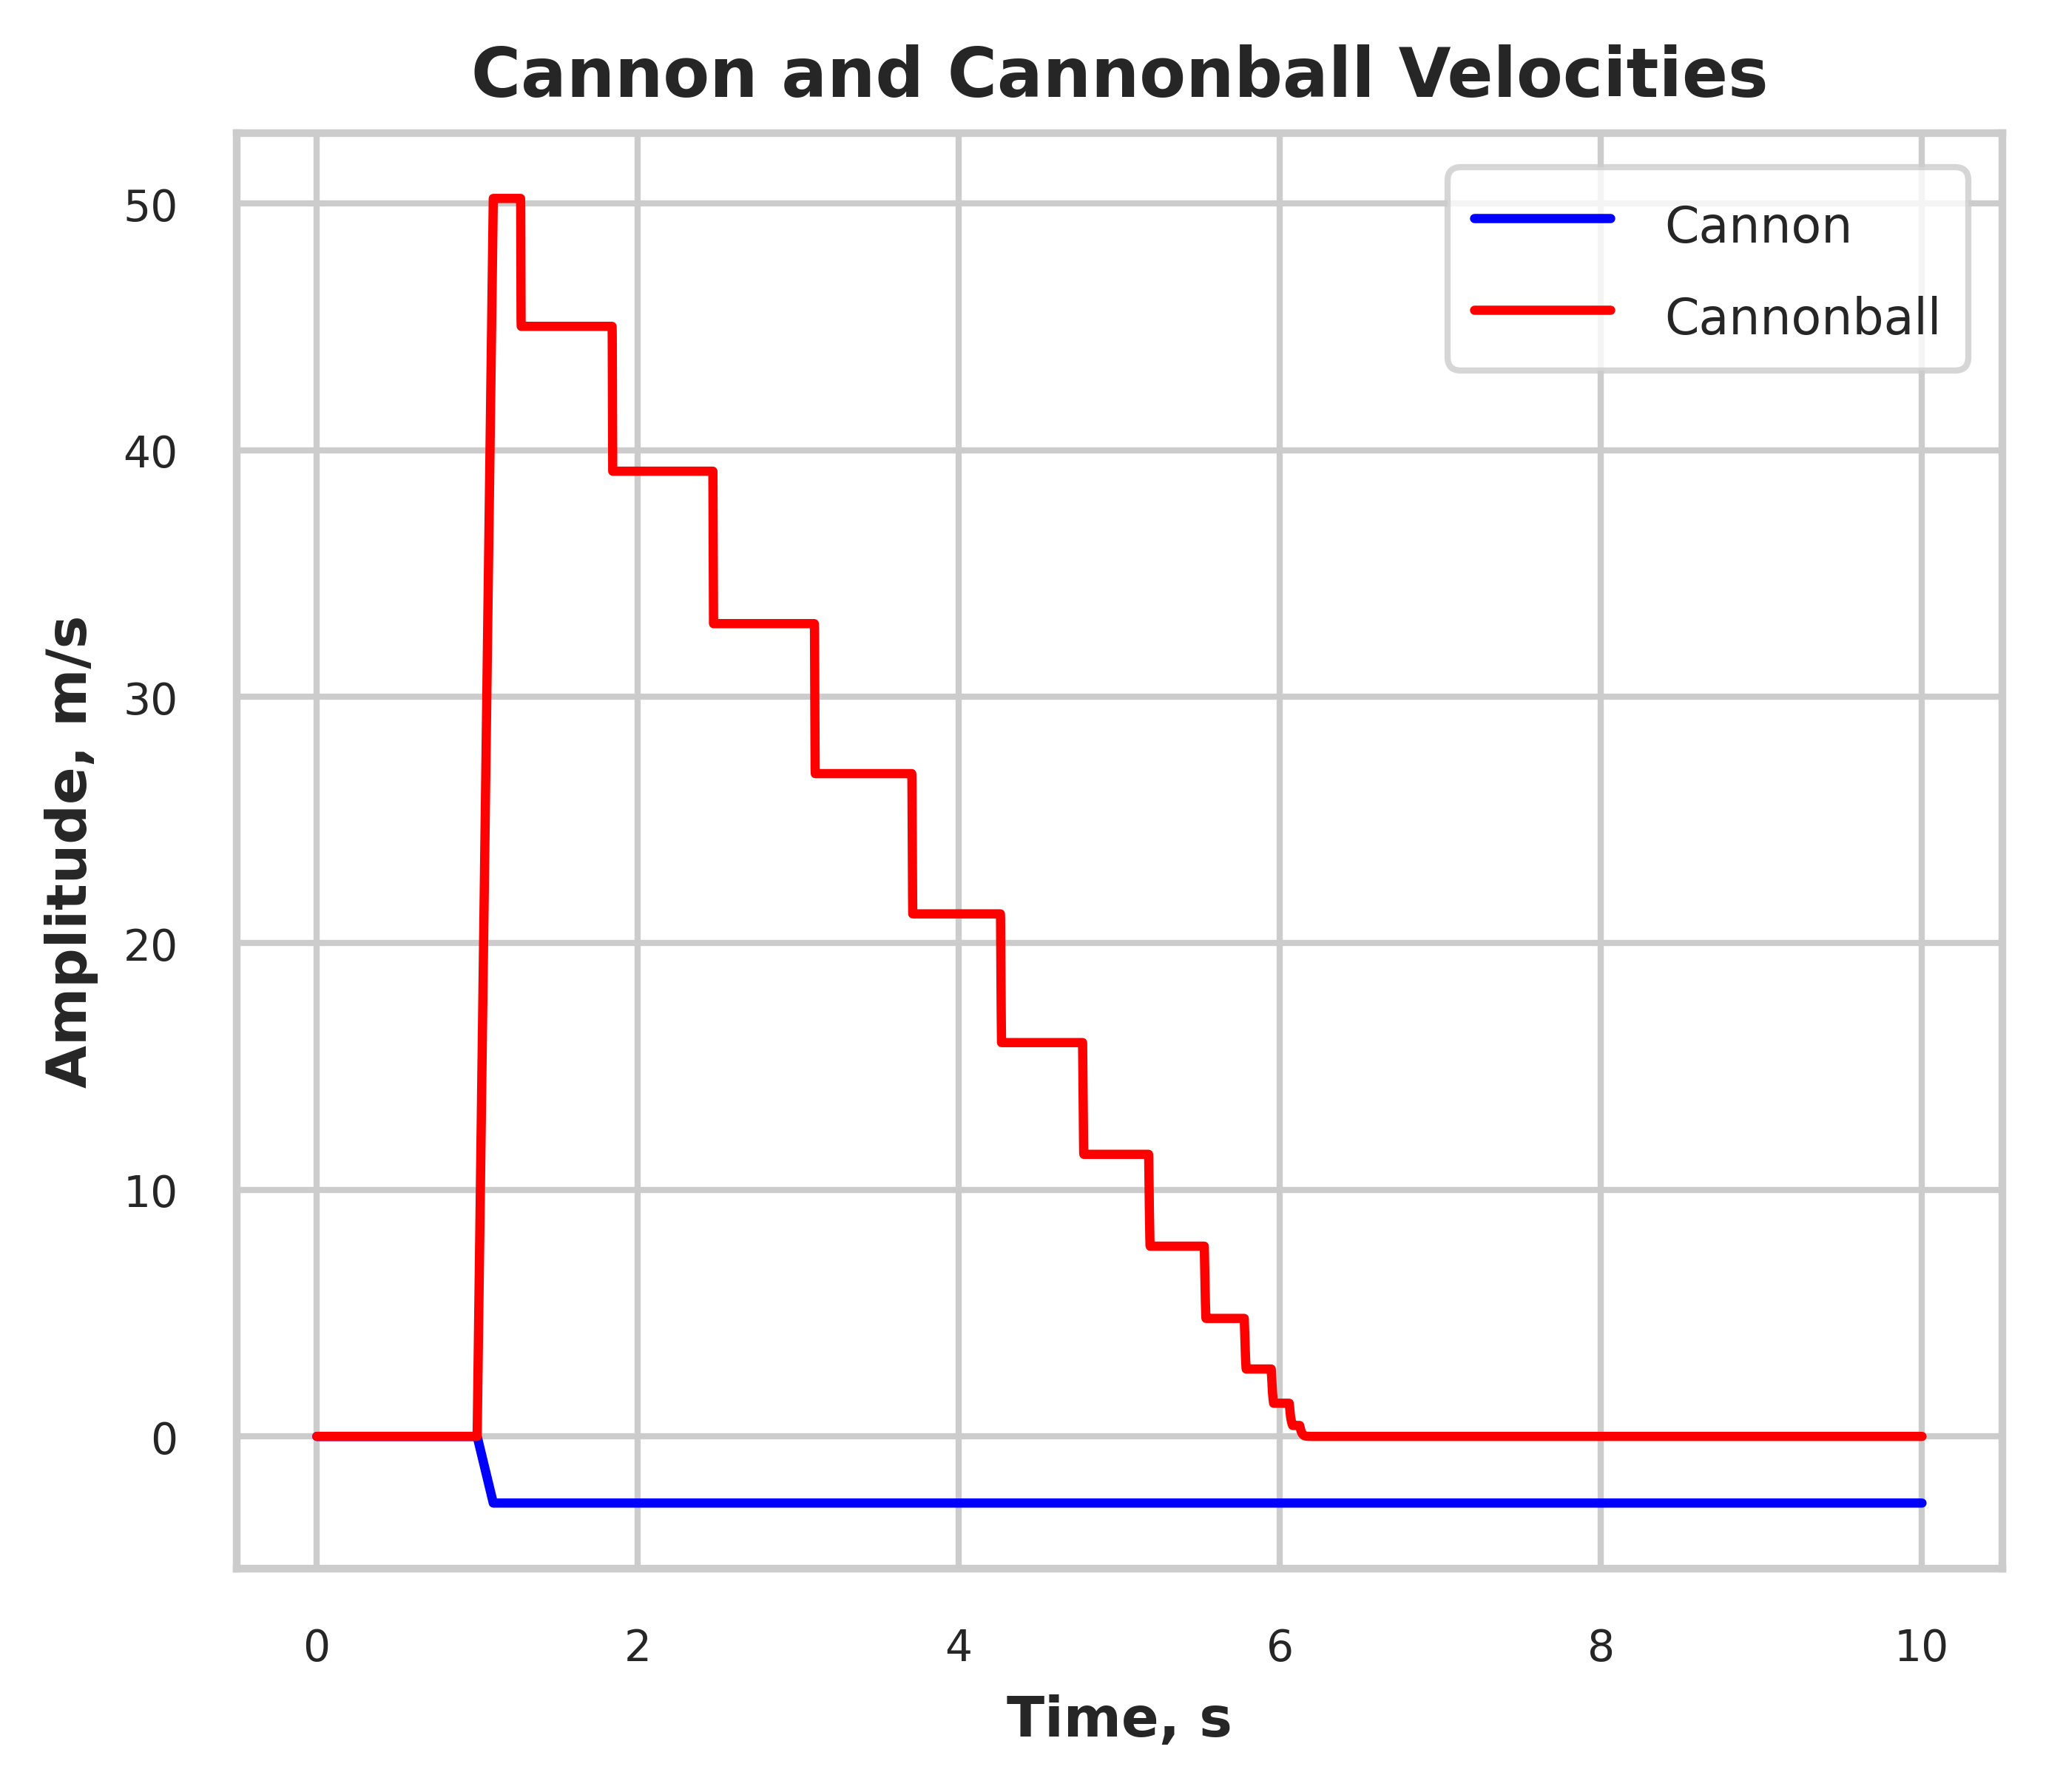

In [18]:
figsize = (width / dpi + 3, height / dpi + 3)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

sns.lineplot(x=timevals, y=cannon_velocity, ax=ax, label="Cannon", color="blue")
sns.lineplot(x=timevals, y=ball_velocity, ax=ax, label="Cannonball", color="red")
ax.set_title("Cannon and Cannonball Velocities", weight="bold", fontsize=11)
ax.set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax.set_xlabel("Time, s", weight="bold", fontsize=9)
ax.tick_params(labelsize=7)
plt.setp(ax.get_legend().get_texts(), fontsize="8")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="8")  # for legend title

plt.savefig(f"../../output/newton_law_3.png", bbox_inches="tight")